# NLP 2025 Track A -- multilabel text classification

authors:
- Anne Marschner
- Arshia Orangkhadivi
- Jafar Zohourian Moftakharahmadi
- Kirill Kuznetsov
- Moritz Groß

---

### Task description (from Milestone 2)

Given a target text snippet, we aim to predict the
perceived emotion(s) of the speaker. Specifically,
select whether each of the following emotions
apply to the text: anger, fear, joy, sadness, surprise.
This is a multi-label sentiment classification, since
multiple nonexclusive labels may be assigned to
each instance of text.

The library `transformers` by HuggingFace provides access to popular pretrained models. We use the model `distilbert/distilbert-base-uncased`, which has 67 million parameters.

The libarary `datasets` is made by HuggingFace as well and provides easy and clean handling of data for our AI models, and is very compatible with `transformers` as they are from the same creators.

In [13]:
!pip -q install -U transformers datasets nltk matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [14]:
import torch, sklearn, numpy as np, pandas as pd, matplotlib.pyplot as plt
import transformers, datasets   # both from HuggingFace

transformers.set_seed(42)       # ensure deterministic behaviour

## setting up the data


We set the path to the dataset of track A.

In [15]:
csv_path = "track-a.csv"

format transformers Dataset object correctly into a dictionary with 2 keys, `text` and `labels`

In [16]:
label_cols = ["anger", "fear", "joy", "sadness", "surprise"]

raw_ds = datasets.load_dataset("csv", data_files=csv_path)["train"] # all rows

def process_dataset(ex):
    ex["labels"] = [float(ex[c]) for c in label_cols]
    return ex

raw_ds = raw_ds.map(process_dataset, remove_columns=label_cols + ["id"])

now the dataset consists of the input texts and the multilabel prediction is aggregated under the column `labels`

In [17]:
raw_ds

Dataset({
    features: ['text', 'labels'],
    num_rows: 2768
})

We split the dataset into subsets for *training*, *evaluation* and *testing*.

We could not find an easy way to split it into share of 80%/10%/10% in one go, so we split it into 80%/20% first, and then split the 20%-subset again in halves, resulting in the desired partitioning.


In [18]:
# split into train / eval / test
train_tmp  = raw_ds.train_test_split(test_size=0.20, seed=42)
eval_test  = train_tmp["test"].train_test_split(test_size=0.50, seed=42)
ds = {"train": train_tmp["train"], # 80%
      "eval" : eval_test["train"], # 10%
      "test" : eval_test["test"]}  # 10%

### data exploration

All columns we want to predict are binary classifications, encoded as 0 or 1 in the dataset.

In [19]:
for i in range(5):
  print(ds['train'][i])

{'text': "Yea I'm with you there man.", 'labels': [0.0, 0.0, 1.0, 0.0, 0.0]}
{'text': 'I ate a pizza.', 'labels': [0.0, 0.0, 1.0, 0.0, 0.0]}
{'text': 'I turned my head to oncoming headlights.', 'labels': [0.0, 1.0, 0.0, 0.0, 0.0]}
{'text': 'Sometimes, the journey there is just as important.', 'labels': [0.0, 0.0, 1.0, 0.0, 0.0]}
{'text': 'He was just plain GONE into thin air.', 'labels': [0.0, 1.0, 0.0, 1.0, 1.0]}


like mentioned in the project description, we can see that for most labels, only in the minority of the sentences the label is true, in particular for *anger* with just 12 percent.

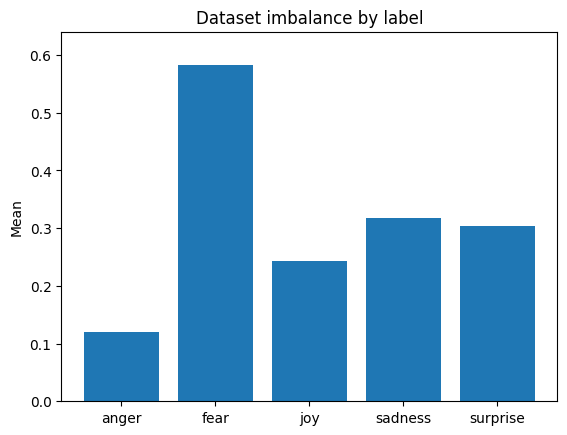

In [20]:
means = pd.read_csv(csv_path)[label_cols].mean()

fig, ax = plt.subplots()
ax.bar(means.index, means.values)
ax.set_ylabel("Mean")
ax.set_title("Dataset imbalance by label")
ax.set_xticks(range(len(means)))
ax.set_xticklabels(means.index)
ax.set_ylim(0, means.max()*1.1)

plt.show()

In unbalanced datasets, using precision and recall is particularly relevant. Assume we have a predictor that only outputs 0 for *anger*, then we would still have accuracy of about 90% (as the share of columns with anger as 1 is only slightly above 10%). In this case, we would notice a recall-value of 0%, as we would archive zero true-positive outputs.

The same principle applies for all categories that are imbalanced, even though it is the strongest for *anger*.

Some labels are heavily correlated, as can be assumed by their meaning. The strongest correlation is between the labels "joy" and "fear", which have a correlation of -0.49, showing the strong opposition of these emotions. The second most negative correlation is "joy" and "sadness".

The strongest *positive* correlation is between "fear" and "sadness", the two emotions which we already mentioned for their strongly negative correlation with "joy".

The lowest correlation is between "anger" and "surprise" with a value of 0.03, which is very close to 0, suggesting that these two emotions are largely unrelated.

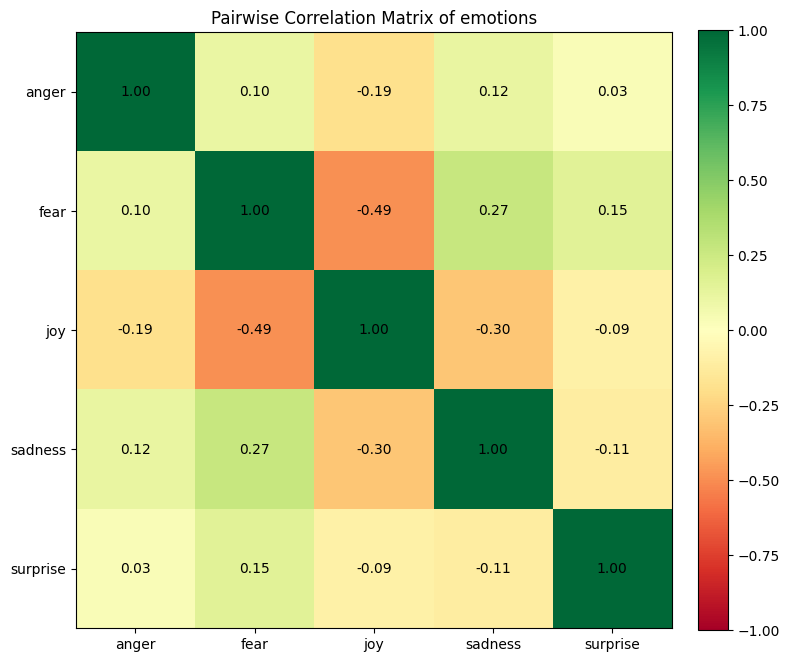

In [21]:
df = pd.read_csv(csv_path)
corr = df.select_dtypes(include="number").corr()

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(corr, cmap='RdYlGn', vmin=-1, vmax=1)

n_emotions = 5
ax.set_xticks(np.arange(n_emotions))
ax.set_yticks(np.arange(n_emotions))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)

for i in range(n_emotions):
    for j in range(n_emotions):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center")

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Pairwise Correlation Matrix of emotions")
plt.tight_layout()
plt.show()

### analyzing common words

Across all the sentences in the dataset, we analyze which words are appearing very frequently. To filter out words that we are not interested in for our task (like "and", "very", "did", ...) we use the library `nlkt` by , which stands for "Natural Language Toolkit".

In [22]:
import re
from collections import Counter
import nltk

nltk.download("stopwords", quiet=True)
stop_words = set(nltk.corpus.stopwords.words("english"))

def iter_tokens(dataset, text_column="text"):
    for doc in dataset[text_column]:
      # all words as lowercase, split by whitespace
        for word in re.findall(r"\b\w+\b", doc.lower()):
            if word not in stop_words:
                yield word

counter = Counter(iter_tokens(raw_ds))
top_30 = counter.most_common(30)

for rank, (word, freq) in enumerate(top_30, start=1):
    print(f"{rank:2d}. {word:<15} {freq}")

 1. head            224
 2. eyes            173
 3. back            168
 4. like            143
 5. one             138
 6. heart           131
 7. get             123
 8. face            121
 9. got             117
10. still           105
11. time            104
12. hand            99
13. day             86
14. went            84
15. could           82
16. see             80
17. going           79
18. felt            78
19. know            77
20. around          73
21. right           72
22. hands           71
23. never           70
24. feet            68
25. really          67
26. started         65
27. go              64
28. away            61
29. first           60
30. well            58


A lot of the top words are concerning the human body, as for example the top 3 are "head", "eyes" and "back". Other than that, many verbs are about human feelings or movement, such as "like", "see", "going", "felt", "started".

This is consistent with the task of predicting human emotions in a text, so there is not need for processing the dataset.

## Tokenization

The `transformers` library directly provides the fitting tokenizer for a given model identifier, in our case `distilbert/distilbert-base-uncased`.

In [23]:
model_identifier = "distilbert/distilbert-base-uncased"
tok = transformers.AutoTokenizer.from_pretrained(model_identifier)
tok_ds  = {k: v.map(lambda x: tok(x["text"])) for k, v in ds.items()}

## AI Training

We use a BERT model from Google, which they developed in 2018.

We download the model `distilbert/distilbert-base-uncased` from HuggingFace, a platform that hosts machine learning models and that develops ML libraries like `transformers` which we use. The full URL for our model is https://huggingface.co/distilbert/distilbert-base-uncased, which also contains more in depth information about it.

`distilbert/distilbert-base-uncased` has about 67 million parameters, which is about the order of magnitude that can comfortable be used and fine-tuned without much cost. Its performance is superseded by later and bigger models like the *Gemma* series by Google aswell, but those have parameter dimension of 1 billion (so 10 times of what we use now), or even far more.

The transformers library allows us the directly create the model from the model identifier on HuggingFace, just like the tokenizer. We specify that we are interested in multi-label classification, as per the problem description. The model constructor needs the number of labels for this, which is 5 in our case.



In the `TrainingArguments` of the `transformers` library, we specify to log training and evaluation loss every epoch for detailed tracking. From manual testing, we observed that setting a lower learning rate than the default archieves a better final result, likely as the default parameters are tuned for bigger datasets than what we are working with. Similarly, we specify a higher weight decay, as otherways the model heavily overfits, with the validation loss increasing towards the end, while the training loss becomes nearly 0.

In addition to the training and validation loss, we track the micro-F1 throughout the training because of the label imbalance we discussed earlier.

In [24]:
bert_model = transformers.AutoModelForSequenceClassification.from_pretrained(
            model_identifier,
            num_labels=len(label_cols),
            problem_type="multi_label_classification")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs  = torch.sigmoid(torch.tensor(logits)).numpy()
    preds  = (probs > 0.5).astype(int)
    micro_f1 = sklearn.metrics.f1_score(labels, preds, average="micro")
    return {"micro_f1": micro_f1}

args = transformers.TrainingArguments(
    output_dir="output_dir",
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    report_to="none",
    learning_rate=1e-5, # small data -> small lr; default is 5e-5
    weight_decay=0.5, # regularization
)

trainer = transformers.Trainer(bert_model, args,
                  train_dataset  =tok_ds["train"],
                  eval_dataset   =tok_ds["eval"],
                  tokenizer      =tok,
                  compute_metrics=compute_metrics)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/25/22j442jd1kbbtszy07f7l15h0000gn/T/ipykernel_35299/1636019013.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = transformers.Trainer(bert_model, args,
/Users/moritzgross/PycharmProjects/ED-NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Micro F1
1,0.561300,0.505985,0.464968
2,0.465000,0.449406,0.639676
3,0.400900,0.436550,0.659898
4,0.370400,0.425777,0.667494
5,0.362300,0.422830,0.667513


/Users/moritzgross/PycharmProjects/ED-NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/moritzgross/PycharmProjects/ED-NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/moritzgross/PycharmProjects/ED-NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/moritzgross/PycharmProjects/ED-NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory w

TrainOutput(global_step=695, training_loss=0.4389926004752838, metrics={'train_runtime': 500.9334, 'train_samples_per_second': 22.099, 'train_steps_per_second': 1.387, 'total_flos': 146822611020420.0, 'train_loss': 0.4389926004752838, 'epoch': 5.0})

We run the trained model on the held out testing data and compute the micro-F1 score, which is close to the tracked micro-F1 score logged during training 👍

In [25]:
test_out    = trainer.predict(tok_ds["test"])
test_scores = compute_metrics((test_out.predictions, test_out.label_ids))
print(f"Test micro-F1: {test_scores['micro_f1']:.3f}")

/Users/moritzgross/PycharmProjects/ED-NLP/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test micro-F1: 0.627


Below is the detailed analysis of the results for each emotion individually, including precision and recall. We see that "anger" has the lowest recall, yet the highest accuracy, stemming from the imbalance of this label as seen in the introductory plot.

Four out of five labels have accuracy of over 75%, except for "fear", which is the label closest to being balanced.

In [26]:
# -- predictions -> 0/1 --------------------------------------------------------
probs = torch.sigmoid(torch.tensor(test_out.predictions)).numpy()
preds = (probs > 0.5).astype(int)
true  = test_out.label_ids

# -- 1. standard per-label P/R/F1/support --------------------------------------
print(sklearn.metrics.classification_report(true, preds,
                            target_names=label_cols))

# -- 2. per-label accuracy (binary accuracy for each emotion) ------------------
print("\nPer-label accuracy:")
for lbl, acc in zip(label_cols, (preds == true).mean(axis=0)):
    print(f"  {lbl:<8}: {acc:.4f}") # align prints nicely

# -- 3. per-row accuracies -----------------------------------------------------
print("\nGlobal Accuracies")
print(f"exactly correct rows        : {(preds == true).all(axis=1).mean():.3f}")
print(f"accuracy across all fields  : {(preds == true).mean():.3f}")

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        37
        fear       0.67      0.83      0.74       143
         joy       0.75      0.53      0.62        79
     sadness       0.61      0.55      0.58        84
    surprise       0.74      0.49      0.59        79

   micro avg       0.68      0.58      0.63       422
   macro avg       0.55      0.48      0.51       422
weighted avg       0.63      0.58      0.59       422
 samples avg       0.58      0.55      0.54       422


Per-label accuracy:
  anger   : 0.8664
  fear    : 0.7004
  joy     : 0.8159
  sadness : 0.7581
  surprise: 0.8051

Global Accuracies
exactly correct rows        : 0.343
accuracy across all fields  : 0.789


/Users/moritzgross/PycharmProjects/ED-NLP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/moritzgross/PycharmProjects/ED-NLP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/moritzgross/PycharmProjects/ED-NLP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf

# Inference script

In [29]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def predict(sentence: str, checkpoint_dir: str = "output_dir/checkpoint-695"):
    tok  = AutoTokenizer.from_pretrained(checkpoint_dir)
    bert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir).eval()

    inputs = tok(sentence, return_tensors="pt")

    # multi-label uses sigmoid, not softmax
    probs = bert_model(**inputs).logits.squeeze(0).sigmoid()
    threshold = 0.50
    labels = ["anger", "fear", "joy", "sadness", "surprise"]

    predicted = [lbl for p,lbl in zip(probs, labels) if p.item() >= threshold]

    print("Sigmoid scores :", {l:round(p.item(),3) for l,p in zip(labels, probs)})
    print("Predicted labels:", predicted or ["<none>"])


predict("hello")

Sigmoid scores : {'anger': 0.109, 'fear': 0.204, 'joy': 0.551, 'sadness': 0.121, 'surprise': 0.434}
Predicted labels: ['joy']
